# Switch / Light example


### concept system modeling according to literature

based on TNO report: Guided root analysis of machine failure, par 5.2

a system is an assembly of components + connections between components

how to define a component?
- define inputs and outputs
- define failure modes
- inputs and outputs are associated with modalities and a modality has properties
- relation between inputs and outputs for normal behavior and for every failure mode

how to define an assembly
- components that are part of the assembly
- how the components are connected

limitations/prerequisites system modeling
- every component has one health and one output variable. multiple inputs are possible
- type names are unique
- variable names are unique and follow strict convention PropertyModalityInputsName

### generate influence diagram from system definition

implementation below uses following steps
- define component (inputs/outputs, ...) as dict
- define connection as dict
- define system as dict
- create diagram
  - generate nodes from dicts and add to influence diagram
  - generate arcs from dict and add to influence diagram

### component specification

- every component has one or more inputs, outputs
- every component has one health
- every component has a type
- inputs/outputs/health have modalities which have properties which have values

probabilities
- health and inputs don't have parents, prior can be determined before hand
- 

In [137]:
# component Switch > Python datastructure dictionary

switch = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.99,0.01]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "yes","no" , "no"], 
            'EnabledStateInputs':  ["yes", "no" ,"yes", "no"],
            'PresentPowerOutputs': ["yes", "no" ,"no" , "no"],
            'health':              ["ok",  "ok" , "ok", "ok"]
        }
    }
}

In [138]:
# component Light > Python datastructure dictionary

light = {
    "type":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "no"], 
            'PresentLightOutputs': ["yes", "no"],
            'health':              ["ok",  "ok"]
        }
    }

}

### connections connect components 
- connections have a name
- connections have two named components and a direction
- connections have a health that is connected to the component that is addressed by the connection

In [139]:
wire = {
    "type":"Wire",
    "start":"PresentPowerOutputs",
    "typeStart":"Switch",
    "end":"PresentPowerInputs",
    "typeEnd":"Light",
    "healthpriorprobability":0.99
}

### system defines assembly
system consists of components and connections between them

In [140]:
structure = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        }
    }
}

structure2 = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    }
}

In [148]:
# create "system"
components = [switch, light]
connections = [wire]
assembly = {
    "components" : components,
    "connections": connections,
    "structure":structure
}

In [149]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re

# structure

In [150]:
# purpose: add Components from system structure to diagram

# diag: pyagrum influence diagram
# comp: specification of 1 component
# name: name to use for component in diagram

# result: nodes for 1 component added to diagram

# per modality a variable is generated and added to diagram
# arcs are created to connect inputs to output and health to output

def addComponentToDiagram(diag, comp, name):
    componentkeys = ["Inputs","Outputs","Healths"]
    keys = comp.keys()
    labels = []
        
    # read inputs, outputs and health, add named variable to diagram 
    for ckey in componentkeys:
        if ckey in keys:  
            for modality in comp[ckey].keys():                                             # get modalities
                modalitylabel = comp[ckey][modality]["modality"]                           # get modality label
                property = comp[ckey][modality]["property"]                                # get property label
                propertyvalues = comp[ckey][modality]["propertyvalues"]                    # get property values
                if(ckey == "Healths"):                                                     # shorter name for health
                    label = str(property + name)
                else:
                    label = str(property + modalitylabel + ckey + name)                    # name variable
                labels.append(label)
                diag.addChanceNode(gum.LabelizedVariable(label, label, propertyvalues))    # add variable to diagram

    # add arcs to connect inputs / health nodes to output within component
    inputvars = []
    for label in labels:
        if(re.search("Inputs", label)):
            inputvars.append(diag.idFromName(label))
        if(re.search("health", label)):
            hvar = diag.idFromName(label)
        if(re.search("Outputs",label)):
            ovar = diag.idFromName(label)
    # add arc for health to output
    diag.addArc(hvar, ovar)
    # add arc for every input to output
    for v in inputvars:
        diag.addArc(v,ovar)        

In [151]:
# purpose: read connection specification and connect components in diagram via arc, 
# create health for connection

# diag: pyagrum influence diagram
# name: name to use for connection in diagram
# connection: type of connection used to find right specification for connection
# startComponent: component from which the connection starts
# endComponent: component that receives connection

# result: connection + health for connection created in diagram

def addConnectionToDiagram(diag, name, connection, startComponent, endComponent):
    diaglabels = diag.names()
    for label in diaglabels:
        if(re.search(startComponent, label)):
            if(re.search(connection['start'], label)):
                startvar = diag.idFromName(label)
        elif(re.search(endComponent, label)):
            if(re.search(connection['end'], label)):
                endvar = diag.idFromName(label)
    diag.addArc(startvar, endvar)
    label = str("health" + name)
    hvar = diag.addChanceNode(gum.LabelizedVariable(label,label,["ok","broken"]))
    diag.addArc(hvar, endvar)

In [152]:
# find the right dict in set of elements (components or connections) by searching typename
def getDictByType(elementType, elementSet):
    found = False
    for c in elementSet:
        if(c["type"] == elementType):
            found = True
            return c
    if(found == False): print("error getDictByType: no dict found for type")

In [153]:
# disassemble system, read systemstructure and add components + connections to diagram
def buildDiagram(diag, assembly):
    systemstructure = assembly["structure"]
    components = assembly["components"]
    connections = assembly["connections"]

    # loop sets (connections, components) in assembly structure
    for set, elements in systemstructure.items():

        # add components from structure to diagram
        if(set =="components"):
            for n, value in elements.items():
                addComponentToDiagram(diag, getDictByType(value["type"], components) ,value['name'])

        #add connections from structure to diagram
        if(set =="connections"):
            for n, connection in elements.items():
                connectionType = getDictByType(connection["type"], connections)
                startComponent = connection["startComponent"]
                endComponent = connection["endComponent"]
                connectionName = connection["name"]
                addConnectionToDiagram(diag,connectionName, connectionType, startComponent, endComponent)


Influence Diagram{
  chance: 8,
  utility: 0,
  decision: 0,
  arcs: 7,
  domainSize: 256
}


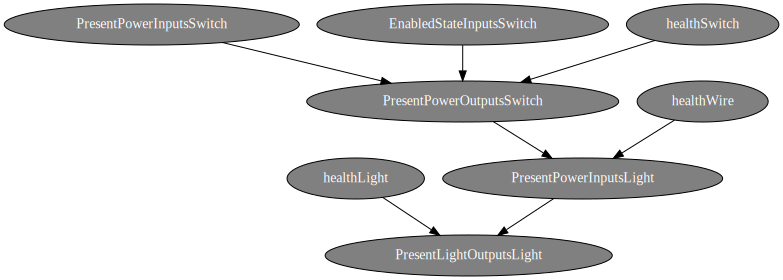

In [155]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# create diagram
diagram = gum.InfluenceDiagram()

# read structure, add to diagram
buildDiagram(diagram, assembly)

# print summary of nodes
print(diagram)

# view structure
gnb.showInfluenceDiagram(diagram, size=60)

# probabilities

todo's:

- determine components in diagram: switch, switch1 etc

Health en Inputs
- set priors van health, dit zijn altijd nodes zonder parent
- set priors van inputs, dit zijn ook nodes zonder parent, alternatieven:
  - eigen prior
  - afleiden uit behaviorstates, kans is 1 -/- failurekansen
  - een setting "expected"

Outputs
- behaviorstates definieren wat normaal is of niet voor hele component, de relatie tussen input / health en output is deterministic en dus 0 of 1, zie par 5.2.3
bijv normal1 voor switch is power in yes / enabled yes > power uit yes
- indien broken dan kans op NO is 1
- indien switch uit dan kans op NO is 1

connecties
- hoe doe je dat bij connecties, de input krijgt er een parent en een health bij

 

In [156]:
import pandas as pd
from deepdiff import DeepDiff

In [157]:
for k, v in switch['Healths'].items():
    print(v['priorprobability'])

[0.99, 0.01]


In [158]:
# determine ids in diagram for named component in diagram
def getIdsForName(name):
    ids = []
    for n in diagram.names():
        if (re.search(v["name"], n)):
            ids.append(diagram.idFromName(n))
    return ids

def setCPTHealthNode(i, componentdict, name):
    for k, v in componentdict['Healths'].items():
        id = diagram.idFromName('health' + name)
        diagram.cpt(id).fillWith(v['priorprobability'])
    
    
def setCPTInputsNode(i, componentdict, name):
    for k, v in componentdict['Inputs'].items():
        id = diagram.idFromName(v['property'] + v['modality'] + "Inputs" + name)
        diagram.cpt(id).fillWith(v['priorprobability'])


# i: id of variable in diagram: 
# componentdict: dictionary from component type
def setCPTOutputsNode(i, componentdict, name):

    # create dataframe based on component normal behavior table
    # rename columns by adding name of component at the rear
    # transform dataframe back to dict but in different format for comparison
    dfNormalStates = pd.DataFrame.from_dict(data = componentdict['Behavior']['normal'])
    dfNormalStates.rename(columns=lambda x: x+name, inplace=True)
    compareDict = dfNormalStates.to_dict('index')


    # CPT has type Potential and contains tuples (Instantiations) of discrete variables
    # loop in CPT, transform tuple to dict
    # if tuple is in normal behavior table: set P(1), else 0
    for tupleVars in diagram.cpt(i).loopIn():
        t1 = tupleVars.todict()
        for k, s in compareDict.items():
            if ('values_changed' not in DeepDiff(s, t1).keys()):
                diagram.cpt(i).set(tupleVars, 1)


In [159]:
# determine probabilities (CPT) for variables of a component

# for every component that is part of the structure
for k, v in assembly["structure"]["components"].items():

    # get id's in diagram for variables that are part of component
    ids = getIdsForName(v["type"])   
    
    # get dict for type of component
    typedict = getDictByType(v["type"],assembly["components"]) 
    
    # for every id validate it's a chancenode, determine probability via method based on input, output or health
    for i in ids:
        if (diagram.isChanceNode(i)):
            if re.search("health", diagram.variable(i).name()):
                setCPTHealthNode(i, typedict, v['name'])
            elif re.search("Inputs", diagram.variable(i).name()):
                setCPTInputsNode(i, typedict, v['name'])
            elif re.search("Outputs", diagram.variable(i).name()):
                setCPTOutputsNode(i, typedict, v['name'])


SizeError: [pyAgrum] incorrect size: Sizes do not match : 8!=2

In [160]:
gnb.flow.row(diagram.cpt(0),
            diagram.cpt(1),
            diagram.cpt(2),
            diagram.cpt(3),

            captions=[  "prior",
                        "prior",
                        "prior",
                        "prior"
                      ])

In [161]:
gnb.flow.row(diagram.cpt(4),
            diagram.cpt(5),
            diagram.cpt(6),
#            diagram.cpt(7),

            captions=[  "prior",
                        "prior",
                        "prior",
#                        "prior"
                      ])

In [168]:
diagram.arcs()

{(0, 1), (2, 1), (3, 5), (4, 5), (5, 0), (6, 5), (7, 0)}

In [169]:
nodeid = 0
for t in diagram.arcs():
    if (t[1] == nodeid):
        print("not good")


not good
not good
